In [ ]:
! pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! mkdir ~/.kaggle

In [5]:
import shutil, sys

In [8]:
newfile = '/root/.kaggle/kaggle.json'
shutil.copyfile("/content/drive/MyDrive/Colab Notebooks/kaggle.json", newfile)

'/root/.kaggle/kaggle.json'

In [9]:
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets download eduardo4jesus/stanford-cars-dataset

Dataset URL: https://www.kaggle.com/datasets/eduardo4jesus/stanford-cars-dataset
License(s): unknown


In [11]:
! unzip stanford-cars-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: cars_train/cars_train/03145.jpg  
  inflating: cars_train/cars_train/03146.jpg  
  inflating: cars_train/cars_train/03147.jpg  
  inflating: cars_train/cars_train/03148.jpg  
  inflating: cars_train/cars_train/03149.jpg  
  inflating: cars_train/cars_train/03150.jpg  
  inflating: cars_train/cars_train/03151.jpg  
  inflating: cars_train/cars_train/03152.jpg  
  inflating: cars_train/cars_train/03153.jpg  
  inflating: cars_train/cars_train/03154.jpg  
  inflating: cars_train/cars_train/03155.jpg  
  inflating: cars_train/cars_train/03156.jpg  
  inflating: cars_train/cars_train/03157.jpg  
  inflating: cars_train/cars_train/03158.jpg  
  inflating: cars_train/cars_train/03159.jpg  
  inflating: cars_train/cars_train/03160.jpg  
  inflating: cars_train/cars_train/03161.jpg  
  inflating: cars_train/cars_train/03162.jpg  
  inflating: cars_train/cars_train/03163.jpg  
  inflating: cars_train/cars_train/03164.jpg  
  inflati

In [12]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image
from pathlib import Path
from matplotlib.patches import Rectangle
from scipy.io import loadmat

In [13]:
devkit_path = Path('/content/car_devkit/devkit')
train_path = Path('/content/cars_train/cars_train')
test_path = Path('/content/cars_test/cars_test')

In [14]:
os.listdir(devkit_path)

['eval_train.m',
 'README.txt',
 'cars_meta.mat',
 'cars_train_annos.mat',
 'cars_test_annos.mat',
 'train_perfect_preds.txt']

In [15]:
cars_meta = loadmat(devkit_path/'cars_meta.mat')
cars_train_annos = loadmat(devkit_path/'cars_train_annos.mat')
cars_test_annos = loadmat(devkit_path/'cars_test_annos.mat')

## Loading Labels

In [16]:
labels = [c for c in cars_meta['class_names'][0]]
labels = pd.DataFrame(labels, columns=['labels'])
labels.head()

,labels
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [17]:
frame = [[i.flat[0] for i in line] for line in cars_train_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname']
df_train = pd.DataFrame(frame, columns=columns)
df_train['class'] = df_train['class']-1 # Python indexing starts on zero.
df_train['fname'] = [train_path/f for f in df_train['fname']] #  Appending Path
df_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname
0,39,116,569,375,13,/content/cars_train/cars_train/00001.jpg
1,36,116,868,587,2,/content/cars_train/cars_train/00002.jpg
2,85,109,601,381,90,/content/cars_train/cars_train/00003.jpg
3,621,393,1484,1096,133,/content/cars_train/cars_train/00004.jpg
4,14,36,133,99,105,/content/cars_train/cars_train/00005.jpg


### Merging labels

In [18]:
df_train = df_train.merge(labels, left_on='class', right_index=True)
df_train = df_train.sort_index()
df_train.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname,labels
0,39,116,569,375,13,/content/cars_train/cars_train/00001.jpg,Audi TTS Coupe 2012
1,36,116,868,587,2,/content/cars_train/cars_train/00002.jpg,Acura TL Sedan 2012
2,85,109,601,381,90,/content/cars_train/cars_train/00003.jpg,Dodge Dakota Club Cab 2007
3,621,393,1484,1096,133,/content/cars_train/cars_train/00004.jpg,Hyundai Sonata Hybrid Sedan 2012
4,14,36,133,99,105,/content/cars_train/cars_train/00005.jpg,Ford F-450 Super Duty Crew Cab 2012


## Loading Cars Test

In [ ]:
frame = [[i.flat[0] for i in line] for line in cars_test_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'fname']
df_test = pd.DataFrame(frame, columns=columns)
df_test['fname'] = [test_path/f for f in df_test['fname']] #  Appending Path
df_test.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,fname
0,30,52,246,147,/content/cars_test/cars_test/00001.jpg
1,100,19,576,203,/content/cars_test/cars_test/00002.jpg
2,51,105,968,659,/content/cars_test/cars_test/00003.jpg
3,67,84,581,407,/content/cars_test/cars_test/00004.jpg
4,140,151,593,339,/content/cars_test/cars_test/00005.jpg


In [19]:

import os
import numpy as np
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from collections import Counter
import random
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import cv2

#crop image based on its bounding box

In [20]:
# Root dataset directory
ROOT_DIR = '/content/cars_train/cars_train'
IMAGE_DIR = os.path.join(ROOT_DIR, 'images')
#CROPPED_DIR = '/kaggle/working/cropped__images'
CROPPED_DIR = '/content/cropped__images'

# crop train
def get_assets(df, i):
    os.makedirs(CROPPED_DIR , exist_ok=True)
    image = plt.imread(df['fname'][i])
    img_name = filename = os.path.basename(df['fname'][i])

    dst_path = os.path.join(CROPPED_DIR, df['labels'][i])
    os.makedirs(dst_path, exist_ok=True)


    x = df['bbox_x1'][i]
    y = df['bbox_y1'][i]
    width = df['bbox_x2'][i] - df['bbox_x1'][i]
    height = df['bbox_y2'][i] - df['bbox_y1'][i]
    x, y, w, h = map(int, [x, y, width, height])
    crop = image[y:y+h, x:x+w]
    cv2.imwrite(os.path.join(dst_path, img_name), crop)





#iterate through train data in order to create crop images

In [21]:
for img_path in range(len(df_train)):
    get_assets(df_train, img_path)

#check crop images

In [22]:
#folder_path = '/kaggle/working/cropped__images'
folder_path = '/content/cropped__images'
# List all files and folders
contents = os.listdir(folder_path)
print(contents)

['GMC Savana Van 2012', 'Nissan 240SX Coupe 1998', 'Chevrolet Corvette Convertible 2012', 'Ferrari 458 Italia Convertible 2012', 'Dodge Challenger SRT8 2011', 'Chevrolet Cobalt SS 2010', 'Lamborghini Gallardo LP 570-4 Superleggera 2012', 'Volvo XC90 SUV 2007', 'Chrysler Town and Country Minivan 2012', 'Audi S6 Sedan 2011', 'Acura RL Sedan 2012', 'Dodge Sprinter Cargo Van 2009', 'Dodge Dakota Crew Cab 2010', 'BMW M5 Sedan 2010', 'Dodge Caliber Wagon 2007', 'Chevrolet Silverado 1500 Classic Extended Cab 2007', 'Spyker C8 Convertible 2009', 'Audi A5 Coupe 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Chevrolet Express Van 2007', 'Cadillac SRX SUV 2012', 'Honda Odyssey Minivan 2007', 'Audi TT RS Coupe 2012', 'Chevrolet Express Cargo Van 2007', 'Chevrolet Impala Sedan 2007', 'Buick Regal GS 2012', 'Hyundai Sonata Hybrid Sedan 2012', 'Ford E-Series Wagon Van 2012', 'BMW 6 Series Convertible 2007', 'Suzuki SX4 Sedan 2012', 'Chrysler Aspen SUV 2009', 'Chevrolet Corvette Ron Fellows Editi

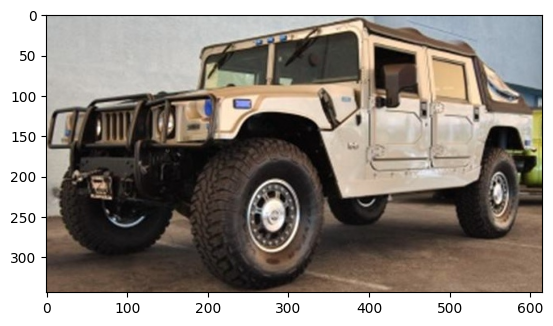

In [23]:
img = plt.imread('/content/cropped__images/AM General Hummer SUV 2000/00163.jpg')
plt.imshow(img)

#crop test data/ since test data has not labeled I slpited train data to creat test data and this part of code has no longer needed

In [ ]:
'''# Root dataset directory
ROOT_DIR = '/content/cars_test/cars_test'
IMAGE_DIR = os.path.join(ROOT_DIR, 'images')
CROPPED_DIR = '/content/cropped__images__test'

# crop train
def get_assets(df, i):
    os.makedirs(CROPPED_DIR , exist_ok=True)
    is_test = df is df_test
    #folder = test_path if is_train else test_path
    image = plt.imread(df['fname'][i])
    img_name = filename = os.path.basename(df['fname'][i])
    #title = df['labels'][i] if is_test else 'Unclassified'


    #src_path = os.path.join(IMAGE_DIR, df_train['fname'][i])
    dst_path = os.path.join(CROPPED_DIR, "test")
    #dst_folder = os.path.dirname(dst_path)
    os.makedirs(dst_path, exist_ok=True)


    x = df['bbox_x1'][i]
    y = df['bbox_y1'][i]
    width = df['bbox_x2'][i] - df['bbox_x1'][i]
    height = df['bbox_y2'][i] - df['bbox_y1'][i]
    #rect = Rectangle(x , y, width, height, fill=False, color='r', linewidth=2)
    x, y, w, h = map(int, [x, y, width, height])
    crop = image[y:y+h, x:x+w]
    cv2.imwrite(os.path.join(dst_path, img_name), crop)


for img_path in range(len(df_test)):
    get_assets(df_test, img_path)
'''


In [ ]:
'''folder_path = '/content/cropped__images__test/test'

# List all files and folders
contents = os.listdir(folder_path)
print(contents)

img = plt.imread('/content/cropped__images__test/test/07159.jpg')
plt.imshow(img)
'''

['07164.jpg', '06874.jpg', '07516.jpg', '01533.jpg', '02547.jpg', '02407.jpg', '06645.jpg', '04902.jpg', '05440.jpg', '01846.jpg', '02346.jpg', '02063.jpg', '02044.jpg', '03359.jpg', '01893.jpg', '02944.jpg', '07723.jpg', '06317.jpg', '05476.jpg', '03449.jpg', '07694.jpg', '07541.jpg', '05936.jpg', '00017.jpg', '04805.jpg', '00322.jpg', '06392.jpg', '06215.jpg', '07674.jpg', '07877.jpg', '02093.jpg', '03346.jpg', '07953.jpg', '07361.jpg', '05328.jpg', '07684.jpg', '04225.jpg', '00580.jpg', '02797.jpg', '07170.jpg', '00867.jpg', '05138.jpg', '04409.jpg', '04606.jpg', '07087.jpg', '06457.jpg', '04600.jpg', '03790.jpg', '04529.jpg', '04754.jpg', '00506.jpg', '02971.jpg', '04997.jpg', '07292.jpg', '06838.jpg', '05515.jpg', '00851.jpg', '05603.jpg', '03566.jpg', '06031.jpg', '00830.jpg', '07829.jpg', '00604.jpg', '01745.jpg', '05561.jpg', '03223.jpg', '05039.jpg', '00712.jpg', '07172.jpg', '06969.jpg', '00317.jpg', '01733.jpg', '03682.jpg', '02046.jpg', '00443.jpg', '00362.jpg', '08013.jpg'

#prepare data for train

In [24]:
#Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#Path to the new dataset
data_dir = '/content/cropped__images'

# Transform for resizing and normalizing images for ResNet50
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the tain dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(full_dataset.classes)

# Total number of data samples
total_size = len(full_dataset)

# Split data into 80-20 ratio (train + validation)
train_val_size = int(0.8 * total_size)
test_size = total_size - train_val_size

# Split the dataset into train_val and test
train_val_dataset, test_dataset = random_split(full_dataset, [train_val_size, test_size])

# split train_val into train and validation
train_size = int(0.7 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

# DataLoader for each part of the dataset
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Display dataset information
print(f'Total Classes: {num_classes}')
print(f'Total Samples: {total_size}')
print(f'Train size: {train_size}')
print(f'Validation size: {val_size}')
print(f'Test size: {test_size}')


Using device: cuda
Total Classes: 196
Total Samples: 8144
Train size: 4560
Validation size: 1955
Test size: 1629


#Bilinearcnn Model

In [49]:
class BilinearCNN(nn.Module):
    def __init__(self, num_classes=196, dropout_rate=0.6):
        super(BilinearCNN, self).__init__()

        # Load the pre-trained ResNet50 model
        backbone = models.resnet50(pretrained=True)

        # Freeze all layers
        for param in backbone.parameters():
            param.requires_grad = False

        # Make the  last layer (layer3) trainable
        for param in backbone.layer3.parameters():
            param.requires_grad = True


        self.features = nn.Sequential(*list(backbone.children())[:-2])
        # Reduce the dimension to 512
        self.reduce_dim = nn.Conv2d(2048, 512, kernel_size=1)
        # Dropout
        self.dropout = nn.Dropout(p=dropout_rate)
        # Fully connected
        self.fc = nn.Linear(512 * 512, num_classes)

    def forward(self, x):

        x = self.features(x)

        x = self.reduce_dim(x)

        x = x.view(x.size(0), 512, -1)

        x = torch.bmm(x, x.transpose(1, 2)) / x.size(2)

        x = x.view(x.size(0), -1)

        x = torch.sign(x) * torch.sqrt(torch.abs(x) + 1e-10)

        x = nn.functional.normalize(x)

        x = self.dropout(x)

        x = self.fc(x)
        return x

# Create the model and move it to the GPU if available
model = BilinearCNN(num_classes=num_classes).to(device)

# Loss function, Optimizer, and Learning Rate Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Early Stopping Class to stop training if validation loss doesn't improve
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        # If the current validation loss is better than the best, reset the counter
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            # If no improvement, increment the counter
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True  # Stop training if patience is exhausted

early_stopping = EarlyStopping(patience=5, min_delta=0.01)

# Training the model
num_epochs = 30
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    # Print the losses for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] → Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Step the learning rate scheduler
    scheduler.step(val_loss)
    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"⛔ Early stopping at epoch {epoch+1}")
        break

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/30] → Train Loss: 5.1889 | Val Loss: 4.9951
Epoch [2/30] → Train Loss: 4.6773 | Val Loss: 4.4383
Epoch [3/30] → Train Loss: 4.0257 | Val Loss: 3.9032
Epoch [4/30] → Train Loss: 3.3885 | Val Loss: 3.4220
Epoch [5/30] → Train Loss: 2.8209 | Val Loss: 2.9168
Epoch [6/30] → Train Loss: 2.3381 | Val Loss: 2.5836
Epoch [7/30] → Train Loss: 1.9054 | Val Loss: 2.2932
Epoch [8/30] → Train Loss: 1.5691 | Val Loss: 2.0862
Epoch [9/30] → Train Loss: 1.2740 | Val Loss: 1.8725
Epoch [10/30] → Train Loss: 1.0395 | Val Loss: 1.7110
Epoch [11/30] → Train Loss: 0.8487 | Val Loss: 1.6284
Epoch [12/30] → Train Loss: 0.6903 | Val Loss: 1.5187
Epoch [13/30] → Train Loss: 0.5686 | Val Loss: 1.4815
Epoch [14/30] → Train Loss: 0.4778 | Val Loss: 1.4269
Epoch [15/30] → Train Loss: 0.3988 | Val Loss: 1.3650
Epoch [16/30] → Train Loss: 0.3419 | Val Loss: 1.3528
Epoch [17/30] → Train Loss: 0.3005 | Val Loss: 1.3330
Epoch [18/30] → Train Loss: 0.2700 | Val Loss: 1.3320
Epoch [19/30] → Train Loss: 0.2502 | 

#evaluate the model


 Performance on Validation Set:
Accuracy:  0.7223
Top-5 Accuracy:  0.9192
Precision: 0.7426
Recall:    0.7224
F1-Score:  0.7138
Balanced Accuracy: 0.7223


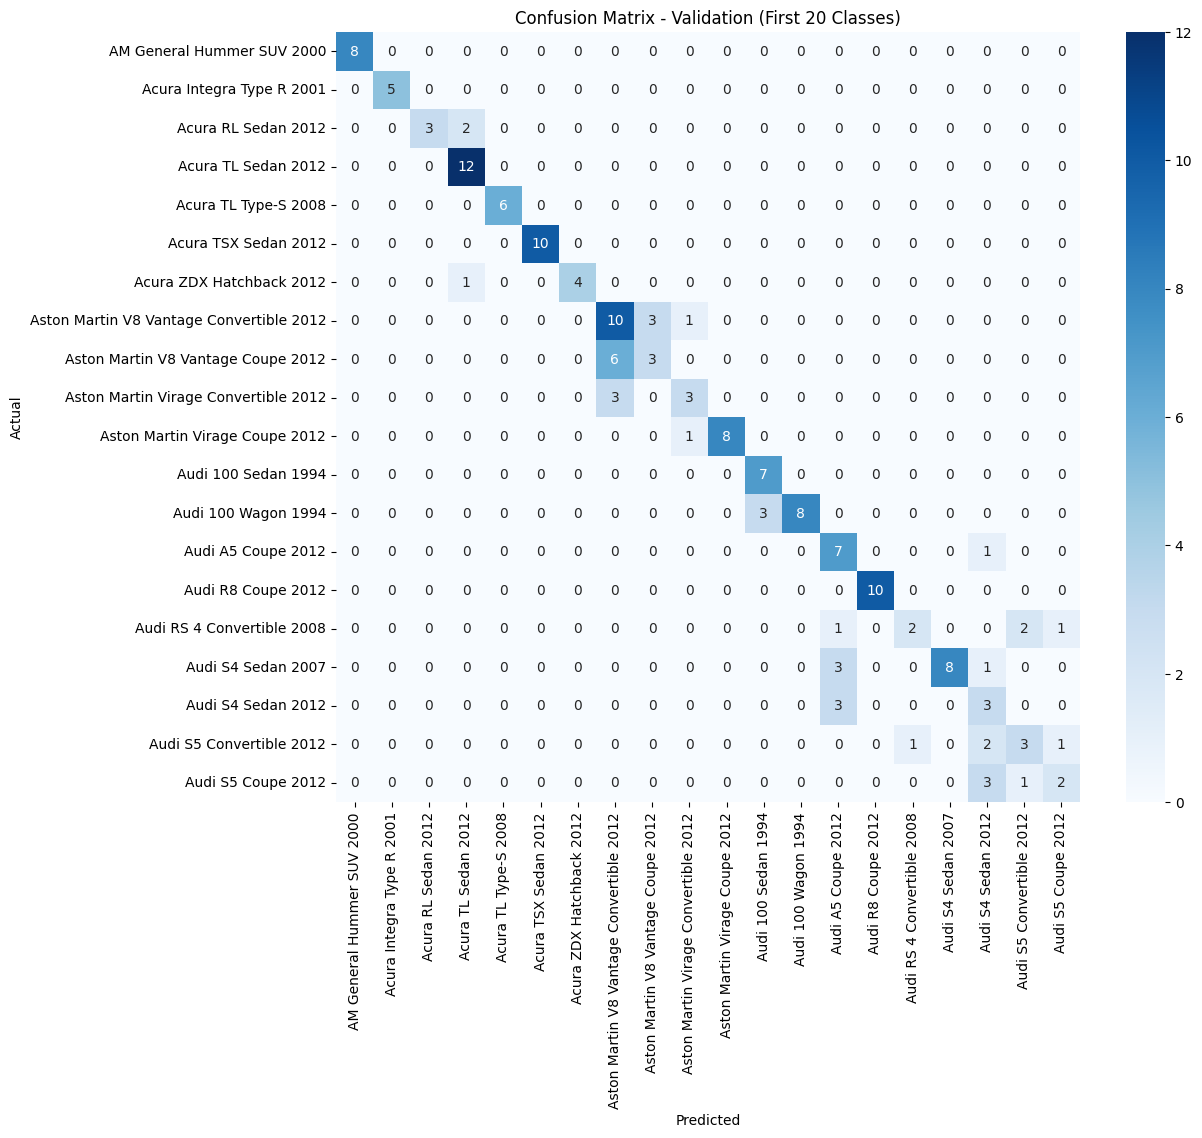

In [ ]:
def evaluate_model(model, dataloader, dataset_name):
    model.eval()
    all_preds = []
    all_labels = []
    top5_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # For Top-5 Accuracy
            _, top5 = torch.topk(outputs, 5, dim=1, largest=True, sorted=True)


            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            top5_preds.extend(top5.cpu().numpy())

    #Calculate Metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    # Calculate Top-5 Accuracy
    top5_acc = np.mean([1 if lbl in top5 else 0 for lbl, top5 in zip(all_labels, top5_preds)])

    # Calculate Balanced Accuracy
    balanced_acc = np.mean([accuracy_score([lbl], [lbl_pred]) for lbl, lbl_pred in zip(all_labels, all_preds)])

    # Print performance metrics
    print(f"\n Performance on {dataset_name} Set:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Top-5 Accuracy:  {top5_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Display confusion matrix for the first 20 classes
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm[:20, :20], annot=True, fmt='d', cmap='Blues',
                xticklabels=full_dataset.classes[:20],
                yticklabels=full_dataset.classes[:20])
    plt.title(f"Confusion Matrix - {dataset_name} (First 20 Classes)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Evaluate on the Validation set
evaluate_model(model, val_loader, "Validation")

# Evaluate on the Test set
evaluate_model(model, test_loader, "Test")

#BilinearCNN with attention

In [45]:
# Self-Attention Model
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()

        self.query = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels , kernel_size=1)

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        # Compute the query, key, and value tensors
        query = self.query(x).view(batch_size, -1, height * width)
        key = self.key(x).view(batch_size, -1, height * width)
        value = self.value(x).view(batch_size, -1, height * width)



        # Compute the attention map
        attention = torch.matmul(query, key.transpose(1, 2))
        attention = torch.softmax(attention, dim=-1)


        out = torch.matmul(attention, value)
        out = out.view(batch_size, channels, height, width)
        return out

# Bilinear CNN with Attention Model
class BilinearCNNWithAttention(nn.Module):
    def __init__(self, num_classes=196, dropout_rate=0.6):
        super(BilinearCNNWithAttention, self).__init__()
        backbone = models.resnet50(pretrained=True)

        # Freeze all layers
        for param in backbone.parameters():
            param.requires_grad = False

        # Make only the last layer (layer4) trainable
        for param in backbone.layer4.parameters():
            param.requires_grad = True

        # Extract features from the pre-trained ResNet50 backbone, excluding avgpool and fc layers
        self.features = nn.Sequential(*list(backbone.children())[:-2])
        self.attention = SelfAttention(in_channels=2048)
        self.reduce_dim = nn.Conv2d(2048, 512, kernel_size=1)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(512 * 512, num_classes)
    def forward(self, x):

        x = self.features(x)
        x = self.attention(x)
        x = self.reduce_dim(x)
        x = x.view(x.size(0), 512, -1)
        x = torch.bmm(x, x.transpose(1, 2)) / x.size(2)
        x = x.view(x.size(0), -1)
        x = torch.sign(x) * torch.sqrt(torch.abs(x) + 1e-10)
        x = nn.functional.normalize(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# New model with Attention
model_attention = BilinearCNNWithAttention(num_classes=num_classes).to(device)

#  Loss function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_attention.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):

        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:

            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=5, min_delta=0.01)

#Training the model with Attention
train_losses, val_losses = [], []
num_epochs = 30
for epoch in range(num_epochs):
    model_attention.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_attention(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation loop
    model_attention.eval()
    val_running_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_attention(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] → Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Step the learning
    scheduler.step(val_loss)
    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch [1/30] → Train Loss: 5.2305 | Val Loss: 5.1076
Epoch [2/30] → Train Loss: 4.9823 | Val Loss: 4.8982
Epoch [3/30] → Train Loss: 4.7751 | Val Loss: 4.7210
Epoch [4/30] → Train Loss: 4.6264 | Val Loss: 4.6185
Epoch [5/30] → Train Loss: 4.5085 | Val Loss: 4.5654
Epoch [6/30] → Train Loss: 4.4012 | Val Loss: 4.5911
Epoch [7/30] → Train Loss: 4.3518 | Val Loss: 4.4373
Epoch [8/30] → Train Loss: 4.2612 | Val Loss: 4.4052
Epoch [9/30] → Train Loss: 4.1937 | Val Loss: 4.3853
Epoch [10/30] → Train Loss: 4.1427 | Val Loss: 4.3141
Epoch [11/30] → Train Loss: 4.0971 | Val Loss: 4.2547
Epoch [12/30] → Train Loss: 4.0274 | Val Loss: 4.2134
Epoch [13/30] → Train Loss: 3.9616 | Val Loss: 4.2000
Epoch [14/30] → Train Loss: 3.9162 | Val Loss: 4.1798
Epoch [15/30] → Train Loss: 3.8756 | Val Loss: 4.1476
Epoch [16/30] → Train Loss: 3.8186 | Val Loss: 4.0997
Epoch [17/30] → Train Loss: 3.7744 | Val Loss: 4.0806
Epoch [18/30] → Train Loss: 3.7188 | Val Loss: 4.0294
Epoch [19/30] → Train Loss: 3.6902 | 

#evaluate the bilinearCNN with attention


Performance on Validation Set:
Accuracy:  0.0910
Top-5 Accuracy:  0.3995
Precision: 0.0419
Recall:    0.1018
F1-Score:  0.0429
Balanced Accuracy: 0.0910


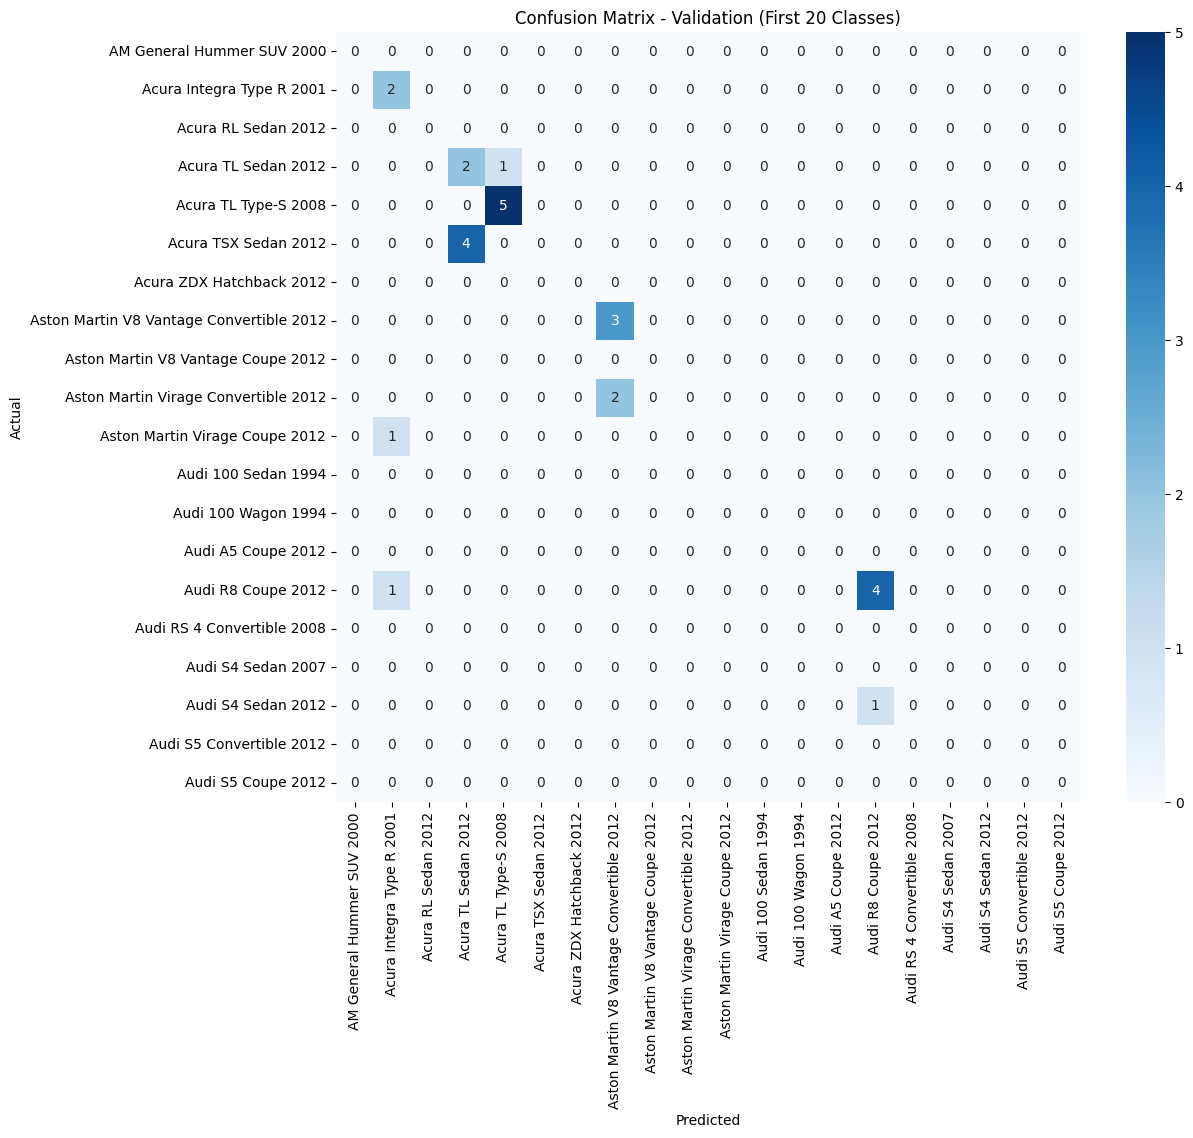


Performance on Test Set:
Accuracy:  0.0884
Top-5 Accuracy:  0.4027
Precision: 0.0297
Recall:    0.0931
F1-Score:  0.0354
Balanced Accuracy: 0.0884


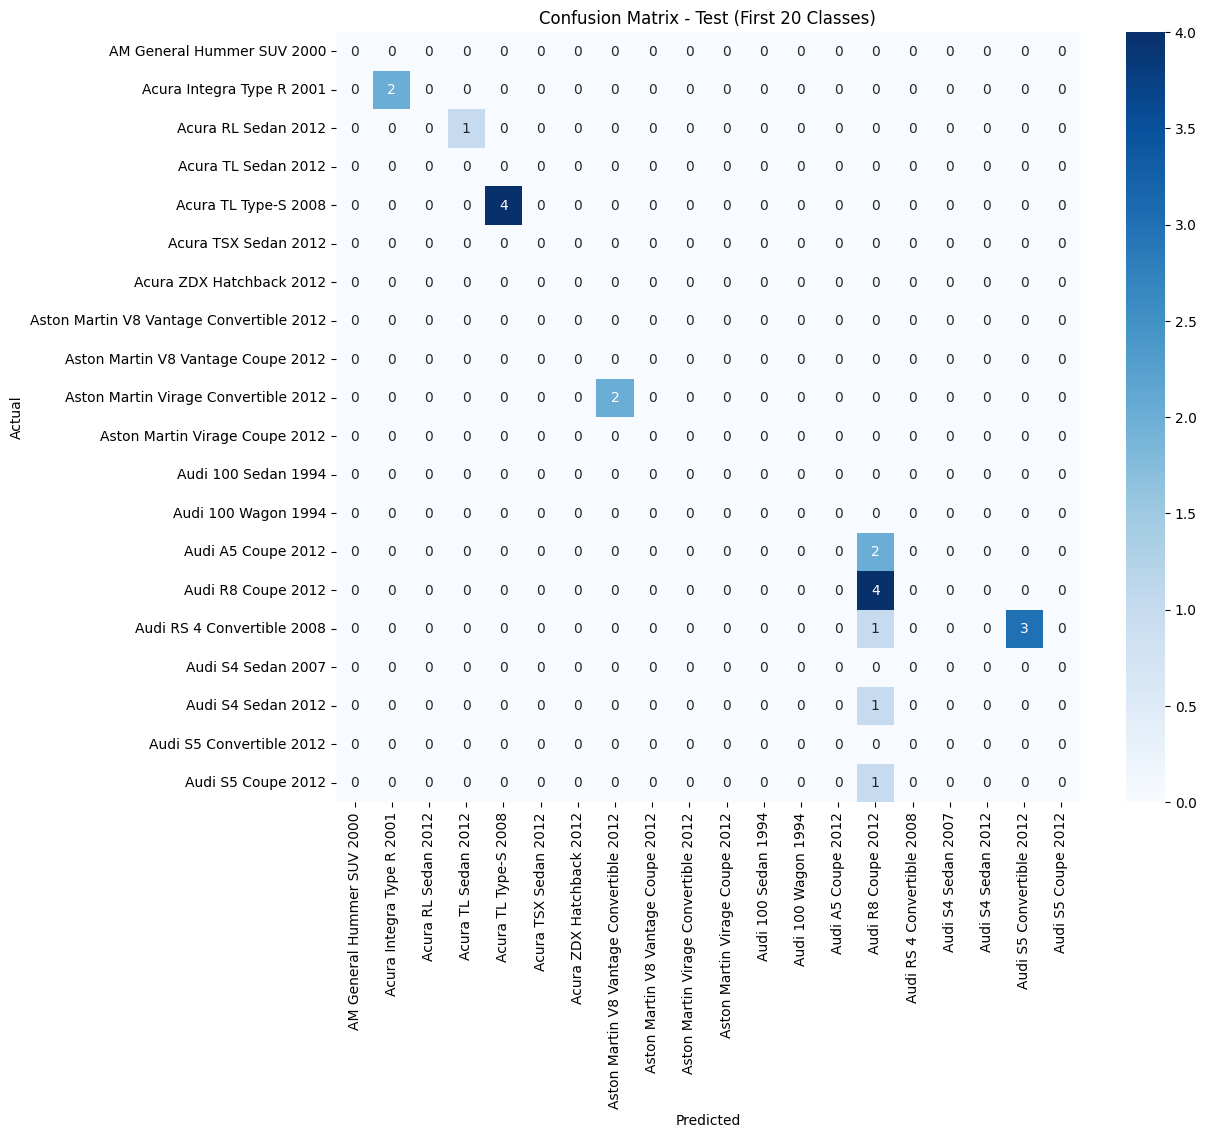

In [46]:
# Function to evaluate the model performance
def evaluate_model(model, dataloader, dataset_name):
    model.eval()

    # Lists to store all predictions, true labels, and top-5 predictions
    all_preds = []
    all_labels = []
    top5_preds = []

    with torch.no_grad():
        # Loop through the dataloader to get batches of images and labels
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # For Top-5 Accuracy
            _, top5 = torch.topk(outputs, 5, dim=1, largest=True, sorted=True)

            # Store the predictions, true labels, and top 5 predictions
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            top5_preds.extend(top5.cpu().numpy())

    # Calculate performance metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    # Calculate Top-5 Accuracy
    top5_acc = np.mean([1 if lbl in top5 else 0 for lbl, top5 in zip(all_labels, top5_preds)])

    # Calculate Balanced Accuracy
    balanced_acc = np.mean([accuracy_score([lbl], [lbl_pred]) for lbl, lbl_pred in zip(all_labels, all_preds)])

    # Print out the performance metrics
    print(f"\nPerformance on {dataset_name} Set:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Top-5 Accuracy:  {top5_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Display confusion matrix for the first 20 classes
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm[:20, :20], annot=True, fmt='d', cmap='Blues',
                xticklabels=full_dataset.classes[:20],
                yticklabels=full_dataset.classes[:20])
    plt.title(f"Confusion Matrix - {dataset_name} (First 20 Classes)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Evaluate on the Validation set
evaluate_model(model_attention, val_loader, "Validation")

# Evaluate on the Test set
evaluate_model(model_attention, test_loader, "Test")